In [11]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [12]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)


In [13]:
df = pd.read_csv(path/'train.csv')

In [14]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [15]:
splits = RandomSplitter(seed=42)(df)

In [16]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

In [17]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

In [18]:
torch.cuda.empty_cache()

SuggestedLRs(slide=0.12022644281387329, valley=0.005248074419796467)

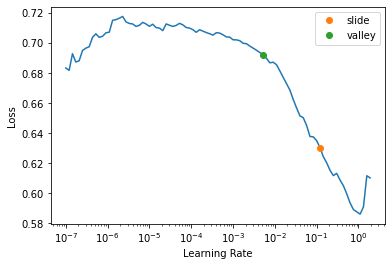

In [19]:
learn.lr_find(suggest_funcs=(slide, valley))

In [20]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.566262,0.563902,0.595506,00:00
1,0.503330,0.477804,0.758427,00:00
2,0.465172,0.423246,0.820225,00:00
3,0.436244,0.443095,0.825843,00:00
4,0.427813,0.468378,0.831461,00:00
5,0.415492,0.453219,0.820225,00:00
6,0.408817,0.441805,0.814607,00:00
7,0.400938,0.417452,0.808989,00:00
8,0.394318,0.425506,0.837079,00:00
9,0.388657,0.446482,0.820225,00:00


In [21]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [22]:
tst_dl = learn.dls.test_dl(tst_df)

In [23]:
preds,_ = learn.get_preds(dl=tst_dl)

In [24]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [25]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
